# Study of ring systems in the dataset

One of the ideas is to study the rings present in our dataset. We had some trouble with the resulting SMILES but it could be solved using the *Chemical Identifier Resolver*, from the CADD group of NCI. To know more about the online service check it out [here](https://cactus.nci.nih.gov/chemical/structure), but it basically returns a plain text request using a simple HTTP endpoint associated to the conversion format.

## Importing packages/libraries

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.drawOptions.addAtomIndices = False
import pandas as pd
import numpy as np

## Importing the data

In [2]:
# Importing the dataset
drugs_db_route_merged = pd.read_csv('../data/approved_drugs_final_2022.csv')

# Get a list of all the SMILES
drugs_smiles = list(drugs_db_route_merged.SMILES)

## Definying the extraction functions

In [3]:
# Definying a function to get all the rings
def get_ring_atoms(mol, includeSpiro=False) -> list:
    """
    Return the atoms of all the rings present in the structure
    Can be used to retrieve the ring SMILES for ex.
    """

    ri = mol.GetRingInfo()
    systems = []
    
    # Function to get the atom index of rings present in the molecule
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    
    # This is a list of lists, maybe you'll need to flatten it for further analysis
    return [list(ring_idx) for ring_idx in systems] 

# Definying a function to get the ring SMILES of a structure
def get_substructure_smiles(smile) -> list:
    """
    Return all the SMILES substructure from the parent molecule
    """
    #transforming the entire structure from SMILES to mol
    mol = Chem.MolFromSmiles(smile)
    substructure_smiles = []

    for ring in get_ring_atoms(mol):
        substructure_smiles.append(Chem.MolFragmentToSmiles(mol, ring, canonical=True))
    return substructure_smiles


## Counting the SMILES of ring systems

In [4]:
rings_on_smiles = []
for drug in drugs_smiles:
    rings_on_smiles.append(get_substructure_smiles(drug))

# We need to flatten the list of rings' smiles because it is a list of list
# I found this solution on STCKOVFLW using numpy
rings_on_smiles = list(np.concatenate(rings_on_smiles))

/home/gustavos/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  warnings.warn(


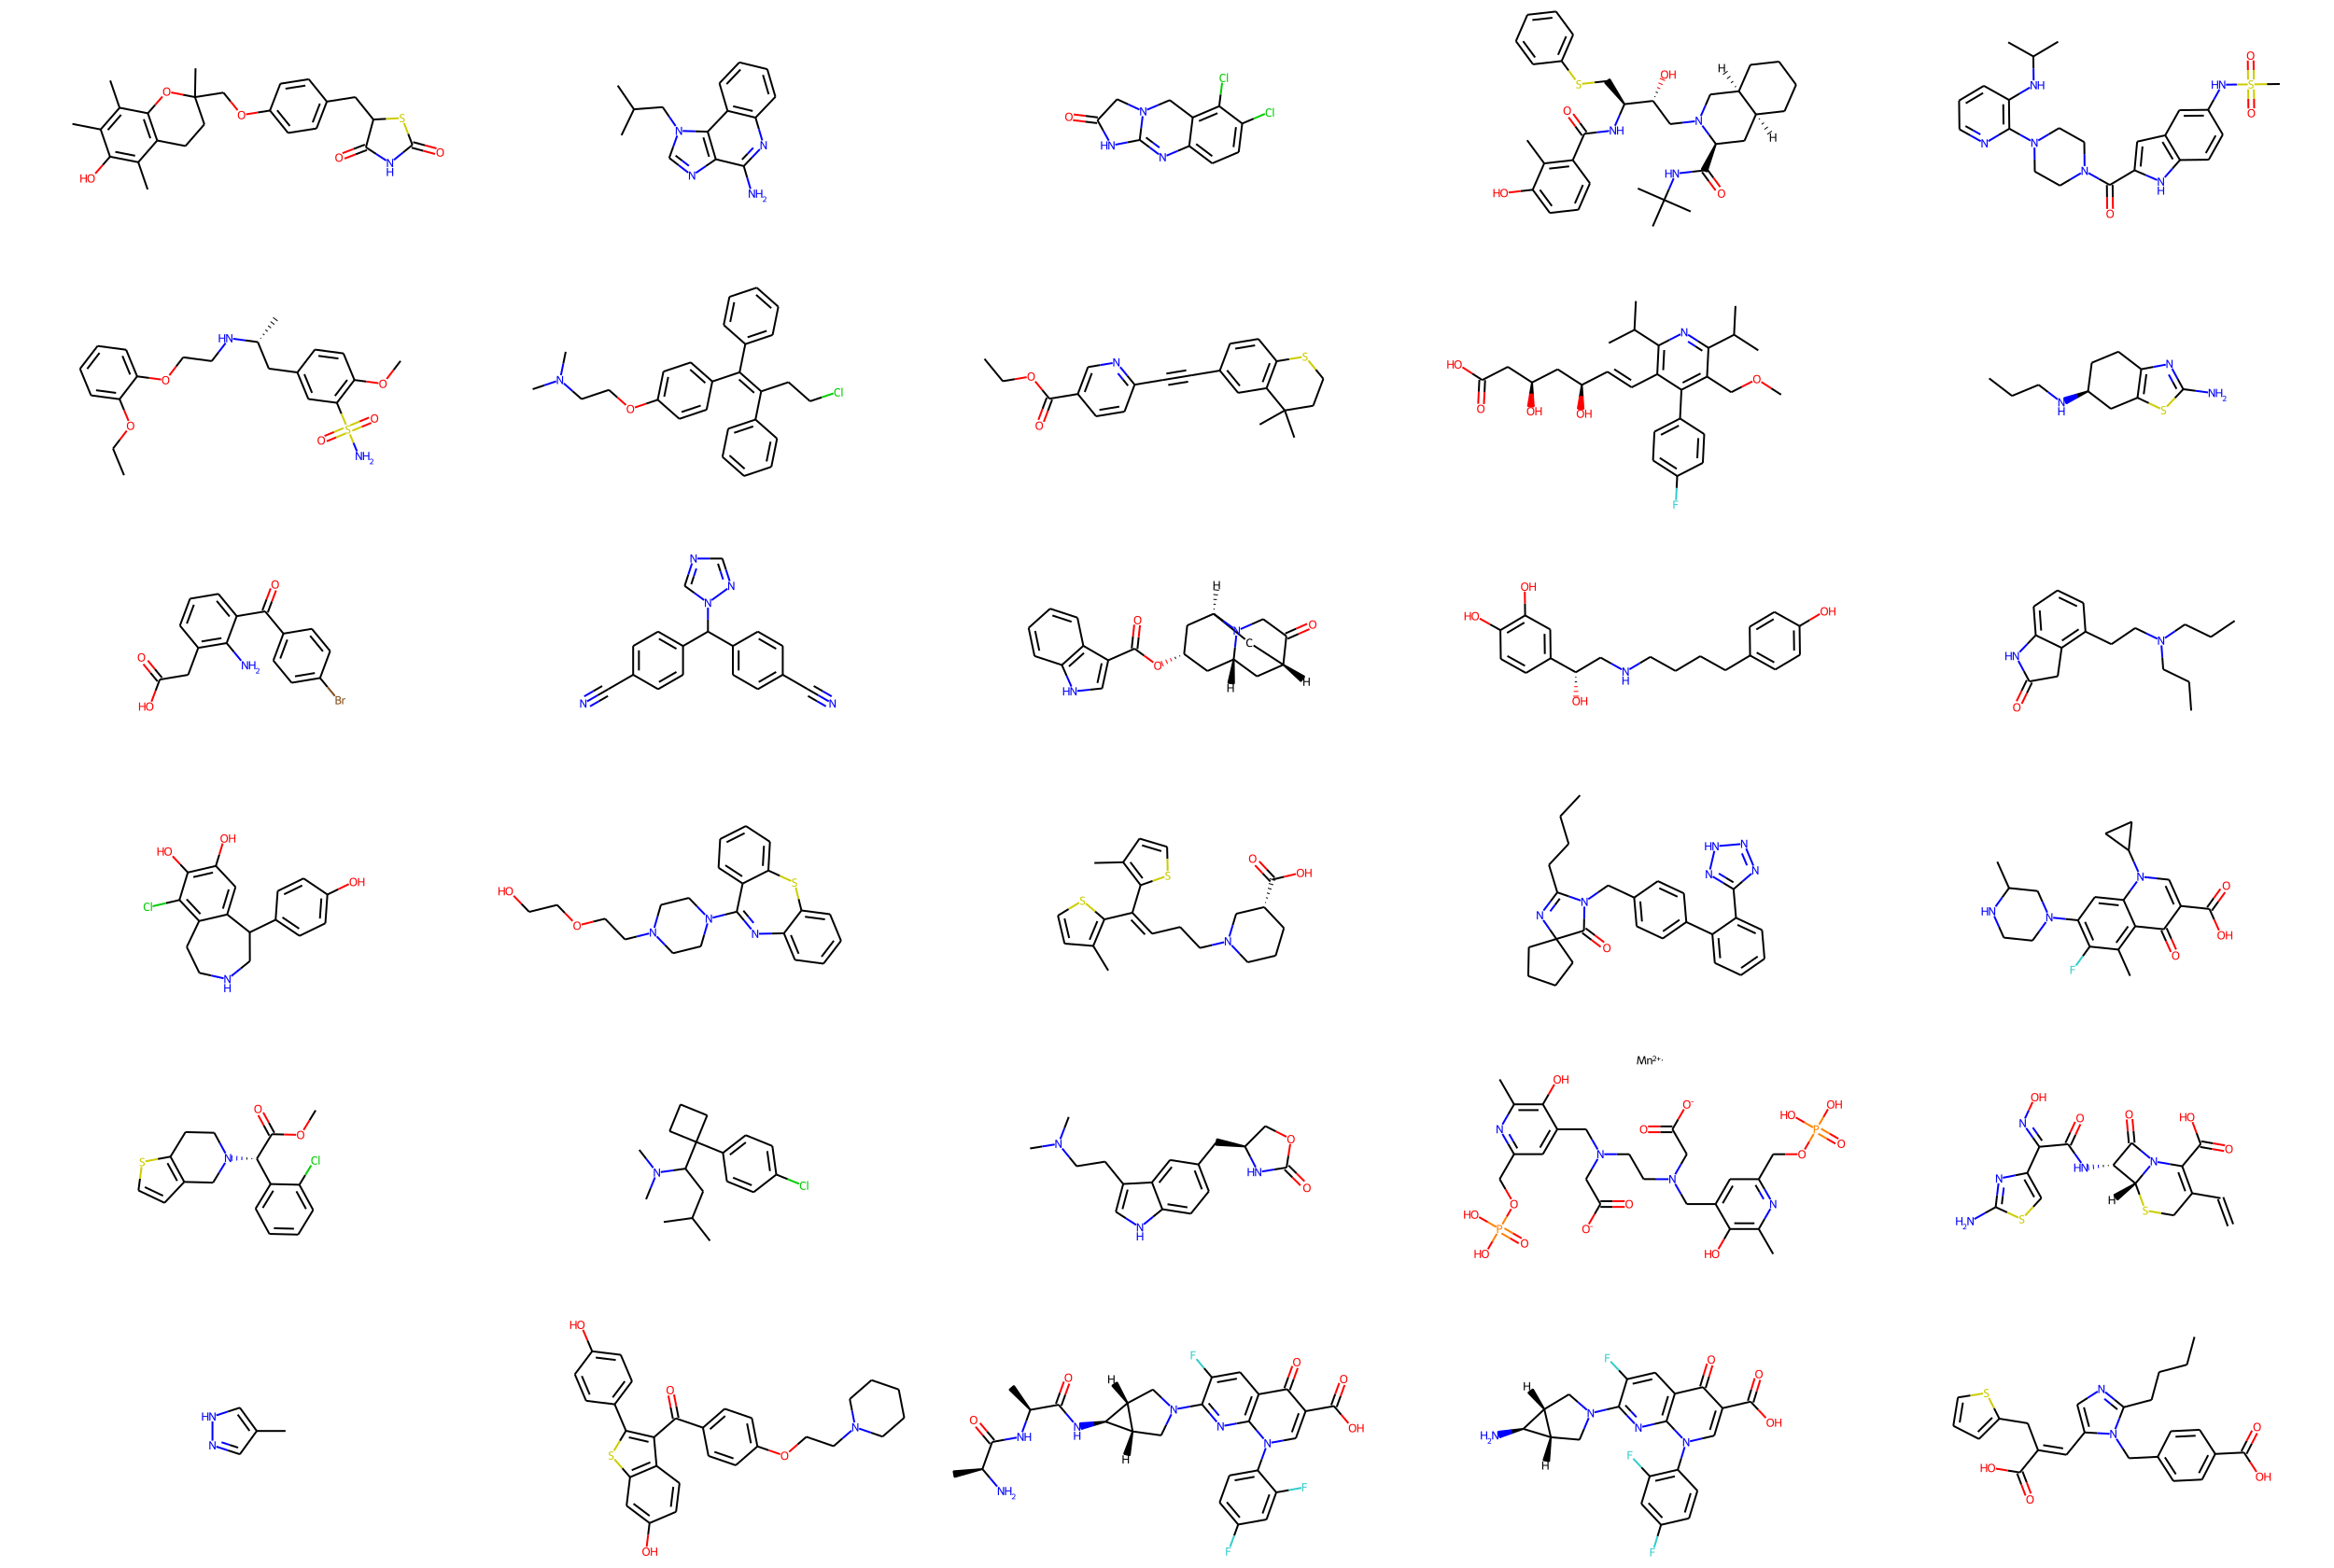

In [5]:
drugs_mol = [Chem.MolFromSmiles(drug) for drug in drugs_smiles]
# Drawing the first n structures
Draw.MolsToGridImage(drugs_mol, subImgSize=(500,280), molsPerRow=5, maxMols=30)

## Fixing non-readable SMILES

The problem is the following: some of the SMILES can't be *'kekulized'*. Turns out that this is totally chemistry related, as two different structures are yielded when we try to convert SMILES directly to mol. One of the solutions is to use the *CACTUS IDENTIFIER RESOLVER*. I did some previous tests and it forces the addition of hydrogen in a systematic way. This temporarily solves our problems.

In [17]:
# Solution to the SMILES not kekulized
import requests
CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'

def check_kekulized(SMILES) -> str:
    """
    Function to check if the SMILES are 'kekulizable' and use the CACTUS CADD Chemical Identifier Resolver 
    to retrieve back a proper convertable SMILES
    
    Obs: When working with SMILES strings that contain triple bonds represented by '#', it is important to 
    note that they have to be URL-escaped as '%23'. For example, the SMILES string for ethyne should be specified as 
    'C%23C' instead of 'C#C' when encoded as part of a URL. Additionally, when dealing with InChI, it is necessary 
    to URL-escape question marks as %3F.*
    """
    smiles_request = f'{CACTUS_END}{SMILES}/smiles'
    response = requests.get(smiles_request)
    converted_smiles = response.text
    
    return converted_smiles

In [18]:
# Counting the SMILES appearances:
counter = {}
for ring_smile in rings_on_smiles:
    ring_smile = check_kekulized(ring_smile)
    counter[ring_smile] = counter.get(ring_smile, 0) + 1

# Transforming it into a pandas object:
rings_df = pd.DataFrame.from_dict(counter, orient='index', columns=['n'])
rings_df = rings_df.reset_index()
rings_df.rename(columns={'index':'SMILES'}, inplace=True)

#  On descending order to ease the vizualization
rings_df = rings_df.sort_values(by='n', ascending=False)
rings_df = rings_df.reset_index(drop=True)
rings_df

,SMILES,n
0,c1ccccc1,478
1,c1ccncc1,78
2,C1CCNCC1,52
3,C1CCNC1,44
4,C1CNCCN1,42
...,...,...
270,C1CNC[C@H]2CSSCC/C=C/[C@H](CCNCCN2)OCCN1,1
271,C1CC2C[C@H]3C(CC[C@H]4OCC34)CCC(=C1)C2,1
272,C1Cc2ccccc2Cc3nccn13,1
273,C1C[C@@H]2C[C@H]1[C@H]3CNC[C@@H]23,1


### Printing the first [n] structures

RDKit ERROR: [22:40:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[22:40:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5


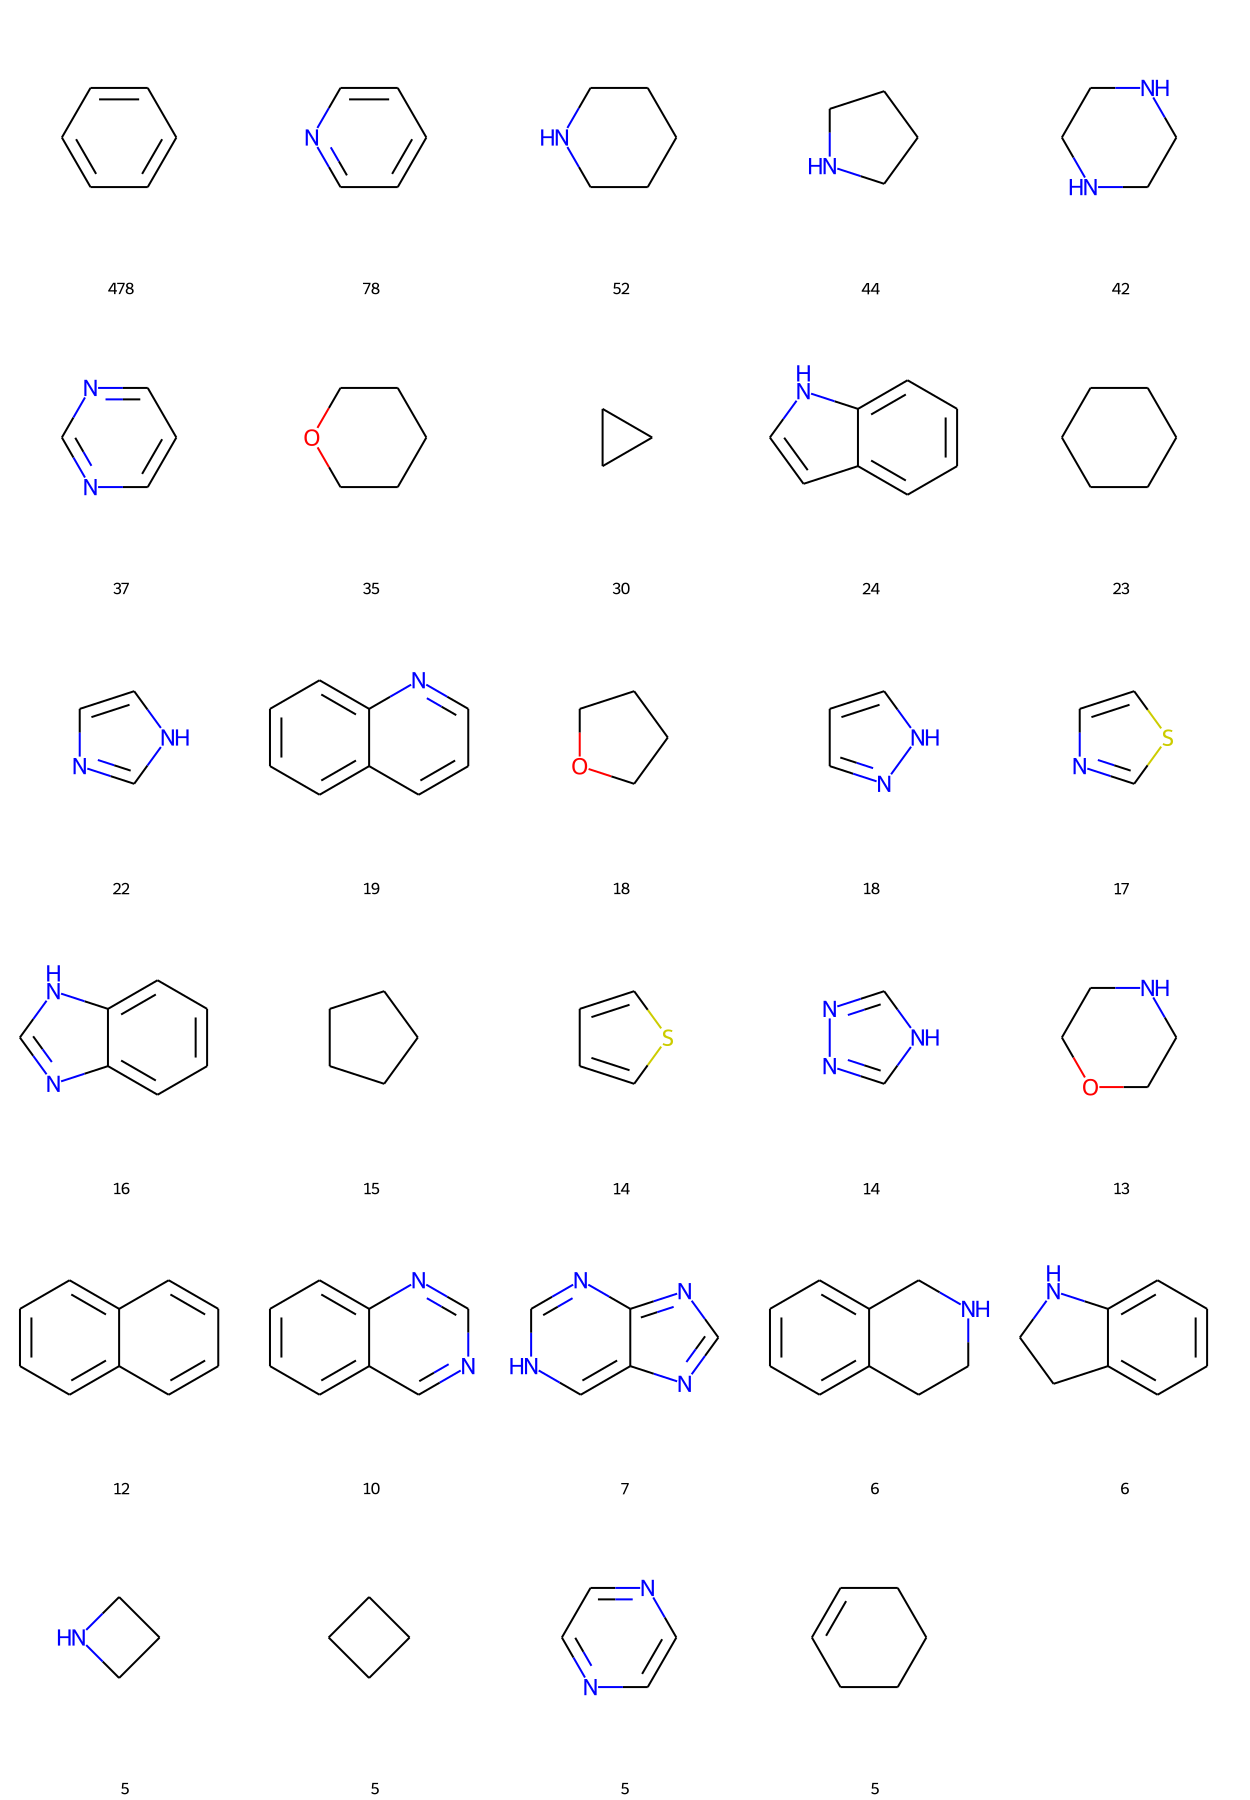

In [26]:
# n most frequent rings in the dataset
mol_rings = [Chem.MolFromSmiles(check_kekulized(SMILES)) for SMILES in list(rings_df.SMILES)[0:30]]
legends = [str(number) for number in list(rings_df.n)]
Draw.MolsToGridImage(mol_rings, legends=legends, molsPerRow=5, maxMols=300, subImgSize=(250,300))

In [28]:
# problem!
rings_df.SMILES[29]

'c1cnc[nH]c1'